In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val
from src.homps import homps
from src.hops import hops

In [4]:
# parameters for the bath correlation functions
g = np.array([2])
w = np.array([0.5+2j])
# time
duration = 50
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
h = operators.generate_spin_boson_hamiltonian()
L = sigma_z

Without noise:


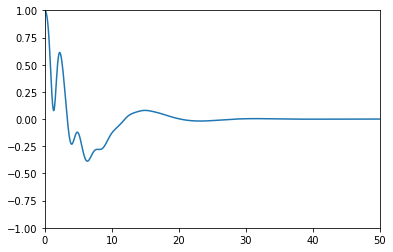

With noise:


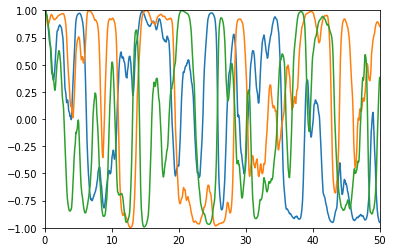

In [97]:
N_steps = 1000
N_trunc = 8
options = {
    'linear' : True,
    'use_noise' : False,
    'method' : 'TDVP',
    'chi_max' : 10,
    'eps' : 1.e-15
}

print("Without noise:")
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
psis = my_homps.compute_realizations(1)
sigma_zs = compute_exp_val(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

print("With noise:")
options['use_noise'] = True
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
for i in range(3):
    psis = my_homps.compute_realizations(1)
    sigma_zs = compute_exp_val(psis, sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

In [21]:
N_steps = 1000
N_trunc = 16

In [28]:
options = {
    'linear' : True,
    'use_noise' : True,
    'method' : 'TDVP',
    'chi_max' : 10,
    'eps' : 1.e-15
}
hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)

In [29]:
psis_100 = hierarchy.compute_realizations(N_samples=100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
#psis_1000 = hierarchy.compute_realizations(N_samples=1000, progressBar=tqdm)

In [32]:
sigma_zs_100 = compute_exp_val(psis_100, sigma_z)
#sigma_zs_1000 = compute_exp_val(psis_1000, sigma_z)

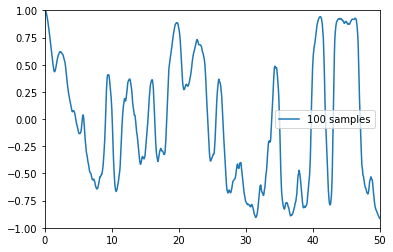

In [33]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
#plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="1000 samples")
plt.legend(loc="right")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

This looks similar to the results we got from HOPS

# Convergence of N_trunc if we don't use noise

In [8]:
N_truncs = [10, 20, 30, 40, 50]
N_steps = 1000
chimax = 10
epsilon = 0
N_krylov = 20

psis_homps_N_trunc_no_noise = np.empty((len(N_truncs), 1, N_steps, 2), dtype=complex)

for n, N_trunc in enumerate(N_truncs):
    print("computing N_trunc =", N_trunc)
    hierarchy = homps.HOMPS_TDVP(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov)
    psis_homps = hierarchy.compute_realizations(1)
    psis_homps_N_trunc_no_noise[n, :, :, :] = psis_homps

computing N_trunc = 10
computing N_trunc = 20
computing N_trunc = 30
computing N_trunc = 40
computing N_trunc = 50


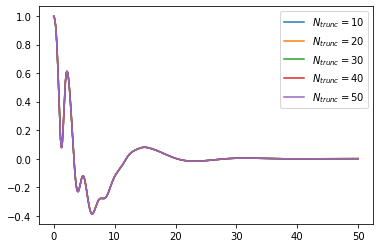

In [9]:
for n, N_trunc in enumerate(N_truncs):
    sigma_zs = compute_exp_val(psis_homps_N_trunc_no_noise[n, :, :, :], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label=r"$N_{trunc} = "+str(N_trunc)+"$")

plt.legend()
plt.show()

# Convergence of N_trunc if we don't use noise (HOPS trotter)

In [96]:
N_truncs = [10, 20, 30, 40, 50]
N_steps = 1000
N_krylov = 10

psis_homps_N_trunc_no_noise_trotter = np.empty((len(N_truncs), 1, N_steps, 2), dtype=complex)

for n, N_trunc in enumerate(N_truncs):
    print("computing N_trunc =", N_trunc)
    hierarchy = hops_trotter_simple.HOPS_Simple_Trotter(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False, N_krylov=N_krylov)
    psis_homps = hierarchy.compute_realizations(1, zts_debug=zts)
    psis_homps_N_trunc_no_noise_trotter[n, :, :, :] = psis_homps

computing N_trunc = 10
computing N_trunc = 20
computing N_trunc = 30
computing N_trunc = 40
computing N_trunc = 50


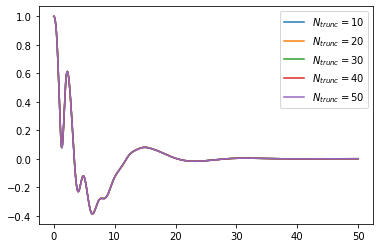

In [97]:
for n, N_trunc in enumerate(N_truncs):
    sigma_zs = compute_exp_val(psis_homps_N_trunc_no_noise_trotter[n, :, :, :], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label=r"$N_{trunc} = "+str(N_trunc)+"$")

plt.legend()
plt.show()

# Fine-tuned comparison

In this section we want to reproduce the exact realization using HOMPS and HOPS

In [90]:
N_steps = 1000
N_trunc = 50
chimax = 10
epsilon = 1.e-15
options = {
    'linear' : True,
    'use_noise' : True,
    'method' : 'TDVP',
    'chi_max' : 10,
    'eps' : 1.e-15
}

In [91]:
options['method'] = 'Trotter'
my_hops = hops.HOPS_Engine_Simple(g, w, h, L, duration, N_steps, N_trunc, options)
options['method'] = 'TDVP'
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)

In [92]:
zts = my_hops.generator.sample_process()
#zts = None

In [93]:
print("computing HOPS ...")
psis_hops = my_hops.compute_realizations(1, zts_debug=zts)
print("computing HOMPS ...")
psis_homps = my_homps.compute_realizations(1, zts_debug=zts)

computing HOPS ...
computing HOMPS ...


In [94]:
sigma_zs_hops = compute_exp_val(psis_hops, sigma_z)
sigma_zs_homps = compute_exp_val(psis_homps, sigma_z)

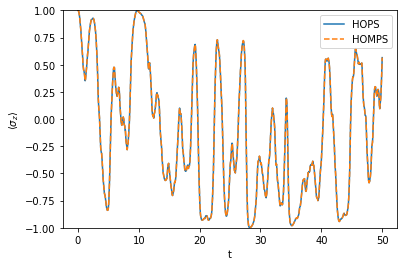

In [95]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_hops, label="HOPS")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_homps, "--", label="HOMPS")
plt.ylabel(r"$\left\langle\sigma_z\right\rangle$")
plt.xlabel("t")
plt.legend()
plt.ylim(-1, 1)
plt.show()

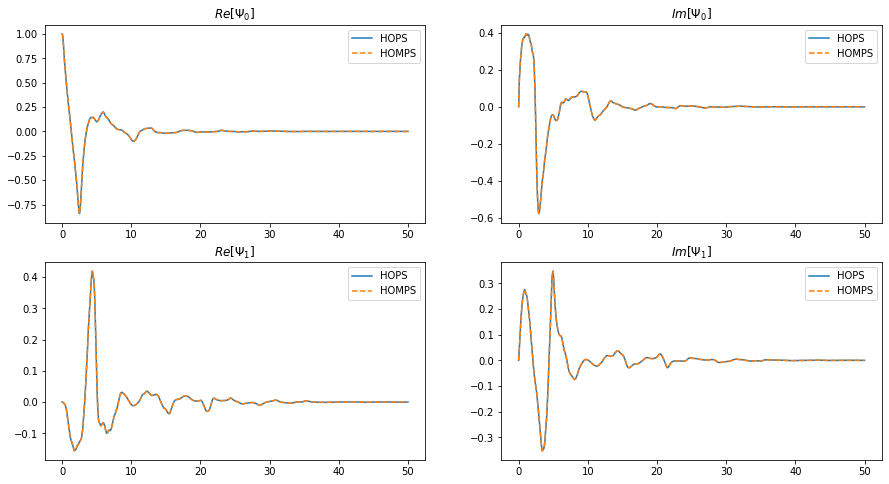

In [96]:
figure, axarray = plt.subplots(2, 2, figsize=(15, 8))

axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_hops[0, :, 0]), label="HOPS")
axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps[0, :, 0]), "--", label="HOMPS")
axarray[0][0].legend()
axarray[0][0].set_title(r"$Re\left[\Psi_0\right]$")

axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_hops[0, :, 0]), label="HOPS")
axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps[0, :, 0]), "--", label="HOMPS")
axarray[0][1].legend()
axarray[0][1].set_title(r"$Im\left[\Psi_0\right]$")

axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_hops[0, :, 1]), label="HOPS")
axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps[0, :, 1]), "--", label="HOMPS")
axarray[1][0].legend()
axarray[1][0].set_title(r"$Re\left[\Psi_1\right]$")

axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_hops[0, :, 1]), label="HOPS")
axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps[0, :, 1]), "--", label="HOMPS")
axarray[1][1].legend()
axarray[1][1].set_title(r"$Im\left[\Psi_1\right]$")

plt.show()

The realization was reproduced exactly up to N_trunc=50.
For N_trunc = 60 we can see instabilities ...

# Looking at the MPO

In [18]:
N_steps = 1000
N_trunc = 30

In [19]:
hops = hops_trotter_simple.HOPS_Simple_Trotter(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False)
hierarchy = homps.HOMPS_TDVP(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False)

In [20]:
#print(hops.Heff_linear.toarray())

In [21]:
W0 = hierarchy.model.H_mpo[0] # vL vR i i*
W1 = hierarchy.model.H_mpo[1] # vL vR j j*
left_contr = np.zeros(W0.shape[0])
left_contr[0] = 1.
right_contr = np.zeros(W1.shape[1])
right_contr[-1] = 1.
contr = np.tensordot(left_contr, W0, ([0], [0])) # -> vR i i*
contr = np.tensordot(contr, W1, ([0], [0])) # [vR] i i*; [vL] vR j j* -> i i* vR j j*
contr = np.tensordot(contr, right_contr, ([2], [0])) # -> i i* j j*
contr = np.transpose(contr, (2, 0, 3, 1)) # -> i j i* j*
contr = np.reshape(contr, (contr.shape[0]*contr.shape[1], contr.shape[2]*contr.shape[3]))

In [22]:
#print(contr)

In [23]:
print(np.all(hops.Heff_linear.toarray() == contr))

True


The MPO has the expected form.

# Performance analysis

In [8]:
def run_program():
    hierarchy = homps.HOMPS_TDVP(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=True)
    psis_100 = hierarchy.compute_realizations(N_samples=1)

In [11]:
import cProfile
import pstats

profile = cProfile.Profile()
profile.runcall(run_program)
ps = pstats.Stats(profile)

In [23]:
sortby = pstats.SortKey.CUMULATIVE
ps = pstats.Stats(profile).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         2720265 function calls (2632259 primitive calls) in 5.298 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    5.298    5.298 /tmp/ipykernel_15619/2204382098.py:1(run_program)
        1    0.012    0.012    5.297    5.297 /home/benjamin/Documents/Uni/Informatik Bachelorarbeit/code/test/homps/../../src/homps/homps.py:70(compute_realizations)
     1000    0.008    0.000    5.171    0.005 /home/benjamin/Documents/Uni/Informatik Bachelorarbeit/code/test/homps/../../src/tdvp/tdvp.py:61(sweep)
     2000    0.046    0.000    5.163    0.003 /home/benjamin/Documents/Uni/Informatik Bachelorarbeit/code/test/homps/../../src/tdvp/tdvp.py:79(update_bond)
     2000    0.007    0.000    3.974    0.002 /home/benjamin/Documents/Uni/Informatik Bachelorarbeit/code/test/homps/../../src/tdvp/tdvp.py:252(evolve)
     2000    0.052    0.000    3.964    0.002 /home/benjamin/Documents/Uni/Informatik Bachelorarbei

NameError: name 's' is not defined

As expected, almost all time is spent in the expm_krylov and multiply methods.